# Clusterig of the dataset Tabular Playground Series - Jul 2022

Pablo Ariño Fernández, Álvaro Laguna García

## Initialization of the dvc project

```bash
dvc init
```

Then, we download `data.csv` from Kaggle, we save it to the data folder and we add it to the dvc project:

```bash
dvc add data/data.csv
```

We can now commit the changes to the git repository:

```bash
dvc commit
git add data/data.csv.dvc
git commit -m "Added Tabular Playground Series - Jul 2022 dataset"      
```



## Data loading and analysis

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (silhouette_score, 
                             davies_bouldin_score, 
                             jaccard_score, 
                             adjusted_rand_score, 
                             normalized_mutual_info_score)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from tqdm import tqdm
import plotly.express as px
import seaborn as sns
import pickle

from itertools import product
import random
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data/data.csv')
data.head()

id      f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0   0 -0.389420 -0.912791  0.648951  0.589045 -0.830817  0.733624  2.258560   
1   1 -0.689249 -0.453954  0.654175  0.995248 -1.653020  0.863810 -0.090651   
2   2  0.809079  0.324568 -1.170602 -0.624491  0.105448  0.783948  1.988301   
3   3 -0.500923  0.229049  0.264109  0.231520  0.415012 -1.221269  0.138850   
4   4 -0.671268 -1.039533 -0.270155 -1.830264 -0.290108 -1.852809  0.781898   

   f_07  f_08  ...      f_19      f_20      f_21      f_22      f_23  \
0     2    13  ... -0.478412 -0.757002 -0.763635 -1.090369  1.142641   
1     2     3  ... -0.428791 -0.089908 -1.784204 -0.839474  0.459685   
2     5    11  ... -0.413534 -1.602377  1.190984  3.267116 -0.088322   
3     6     2  ...  0.619283  1.287801  0.532837  1.036631 -2.041828   
4     8     7  ... -1.628830 -0.434948  0.322505  0.284326 -2.438365   

       f_24      f_25      f_26      f_27      f_28  
0 -0.884274  1.137896  1.309073  1.463002  0.813527  
1  1.759412 -0.275422 -0.852168  0.562457 -2.680541  
2 -2.168635 -0.974989  1.335763 -1.110655 -3.630723  
3  1.440490 -1.900191 -0.630771 -0.050641  0.238333  
4  1.473930 -1.044684  1.602686 -0.405263 -1.987263  

[5 rows x 30 columns]

First, lets visualize the correlation matrix of the dataset:

<Axes: >

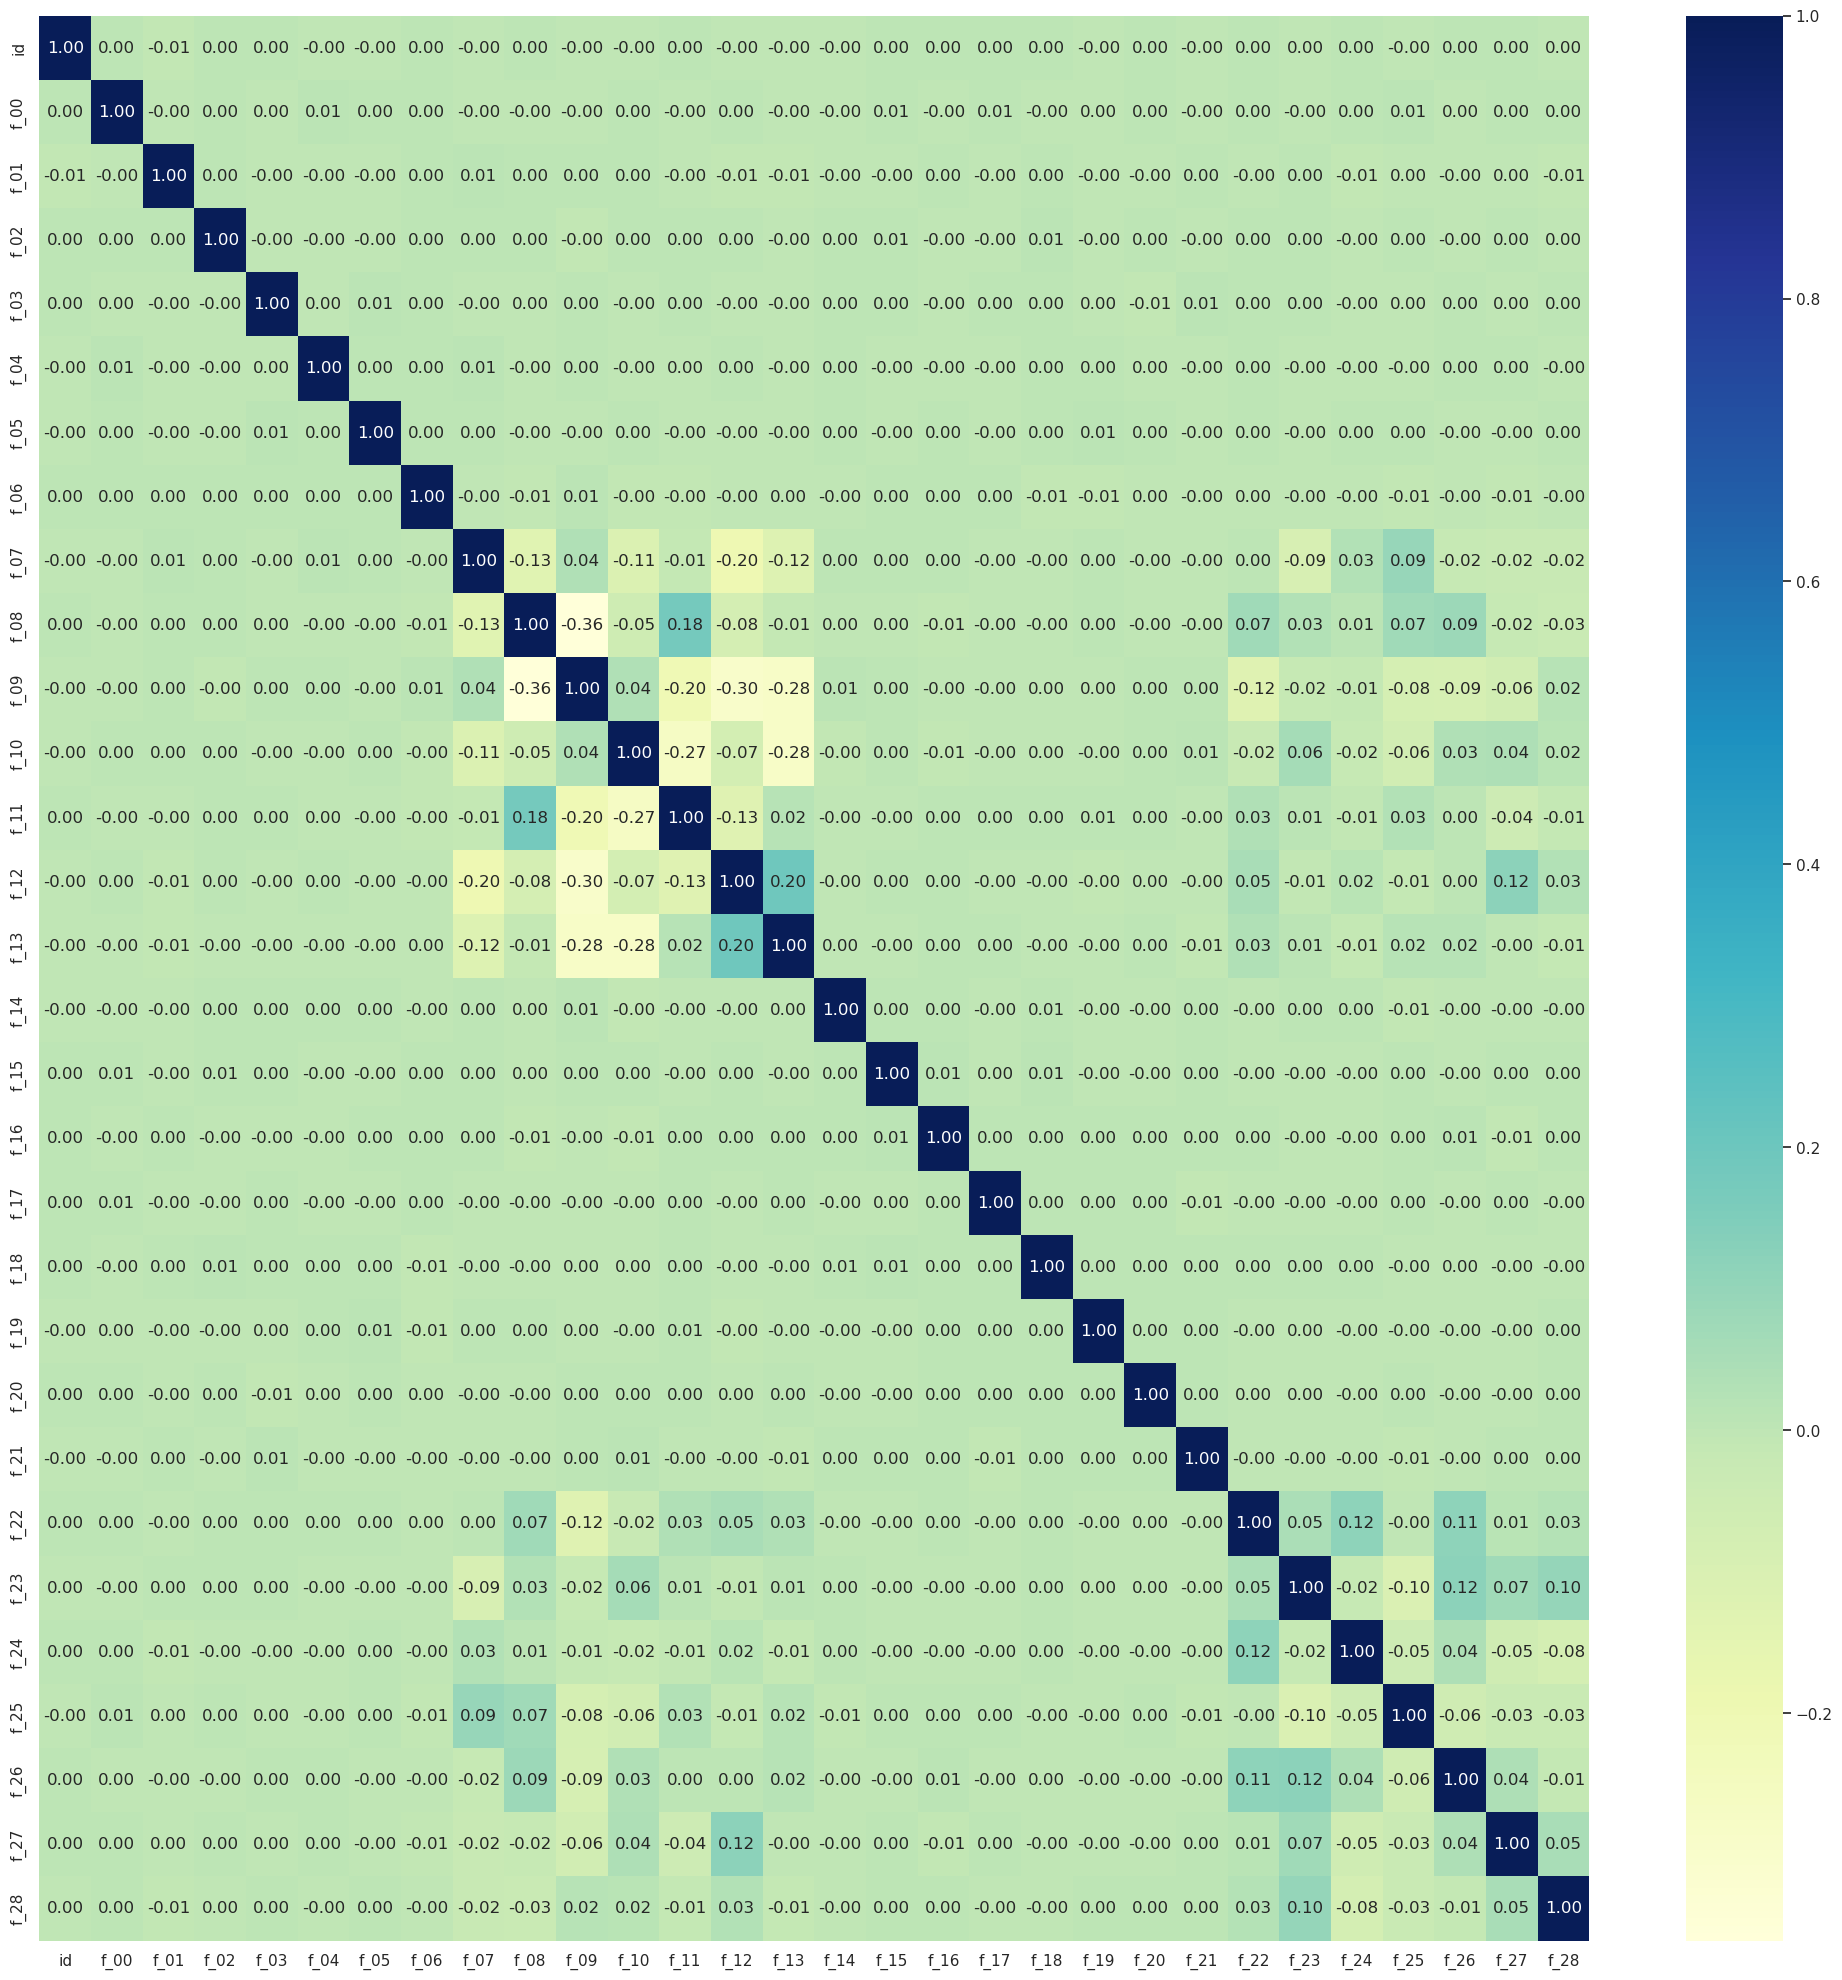

In [7]:
sns.set(rc={'figure.figsize':(25, 25)})
sns.heatmap(data.corr(),annot=True,fmt='.2f', cmap="YlGnBu")

Most of the variables are independent, however some weak correlation can be observed from f_07 to f_13

Now, lets plot the histogram of each variable

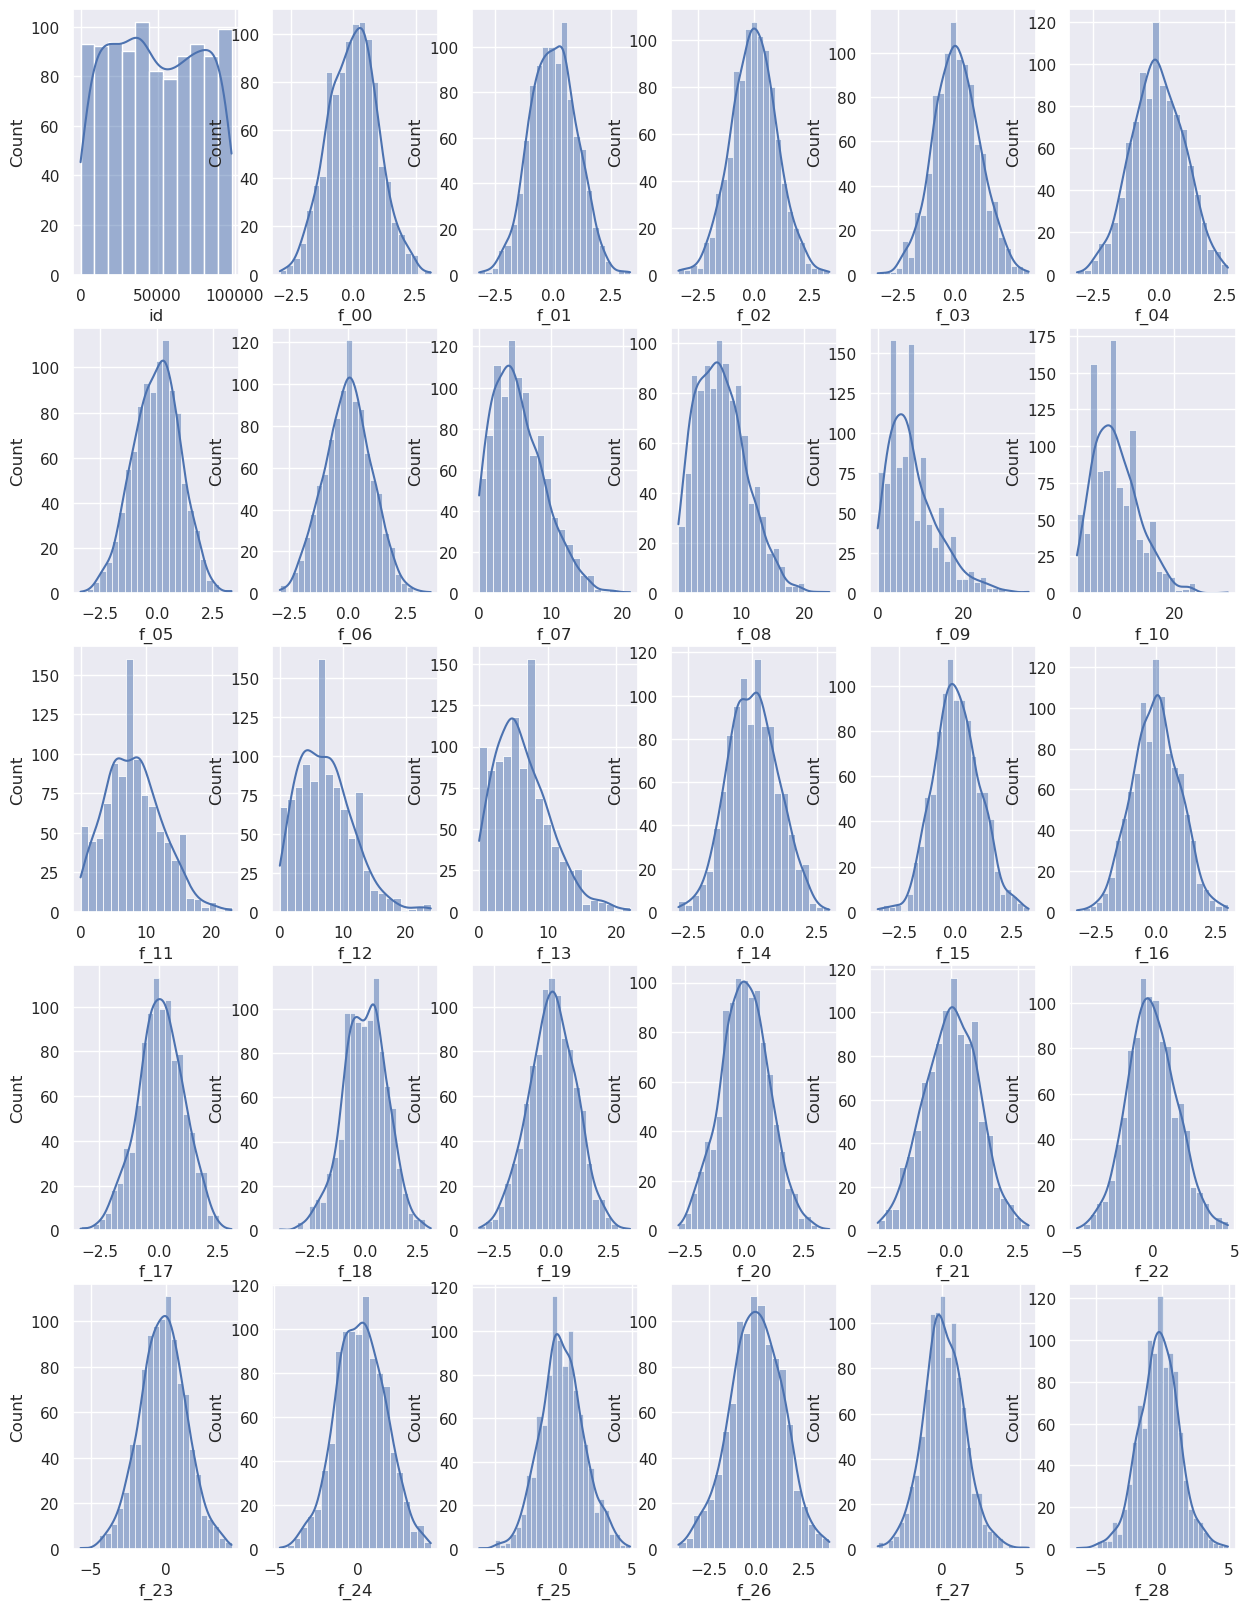

In [33]:
sns.set(rc={'figure.figsize':(15, 20)})
# Plotting the histogram of the dataset
for i, col in enumerate(data.columns):
    plt.subplot(5, 6, i + 1)
    p=sns.histplot(x=col, data=data.sample(1000), stat='count', kde=True)

We can see that the id seems to follow a uniform distribution, which is expected. Also, some of the other columns seem to follow a normal distribution.

Now, lets check which variables are categorical and which are numerical:

In [36]:
for col in data.columns:
    print(col, data[col].nunique())

id 98000
f_00 98000
f_01 98000
f_02 98000
f_03 98000
f_04 98000
f_05 98000
f_06 98000
f_07 32
f_08 29
f_09 45
f_10 37
f_11 29
f_12 39
f_13 30
f_14 98000
f_15 98000
f_16 98000
f_17 98000
f_18 98000
f_19 98000
f_20 98000
f_21 98000
f_22 98000
f_23 98000
f_24 98000
f_25 98000
f_26 98000
f_27 98000
f_28 98000


We can see that the variables that showed some weak correlation between each other are categorical, while the rest are numerical.

We can also check which variables follow a normal distribution:

In [2]:
for col in data.columns:
    stat, p_value = shapiro(data[col])
    if p_value > 0.05:
        print(col, 'is normally distributed')
    else:
        print(col, 'is not normally distributed')

id is not normally distributed
f_00 is normally distributed
f_01 is normally distributed
f_02 is normally distributed
f_03 is normally distributed
f_04 is normally distributed
f_05 is normally distributed
f_06 is normally distributed
f_07 is not normally distributed
f_08 is not normally distributed
f_09 is not normally distributed
f_10 is not normally distributed
f_11 is not normally distributed
f_12 is not normally distributed
f_13 is not normally distributed
f_14 is normally distributed
f_15 is normally distributed
f_16 is normally distributed
f_17 is normally distributed
f_18 is normally distributed
f_19 is normally distributed
f_20 is normally distributed
f_21 is normally distributed
f_22 is not normally distributed
f_23 is not normally distributed
f_24 is not normally distributed
f_25 is not normally distributed
f_26 is not normally distributed
f_27 is not normally distributed
f_28 is not normally distributed


We propose a normalization using PowerTransformer for the non normally distributed variables:

We are going to use dvc to save the data after the normalization:

```bash
dvc run -n powertransform -d src/powertransform.py -d data/data.csv -o data/data_powertransform.csv python src/powertransform.py data/data.csv
git commit -m 'Added PowerTransformer normalization'
```

Now, lets load the new data

In [4]:
data_powertransform = pd.read_csv('data/data_powertransform.csv')

## KMeans clustering

First of all, we are going to use the elbow method to find the optimal number of clusters:

We are going to use inertia, silhouette and davies_bouldin scores to evaluate the clustering:

100%|██████████| 10/10 [12:01<00:00, 72.12s/it]


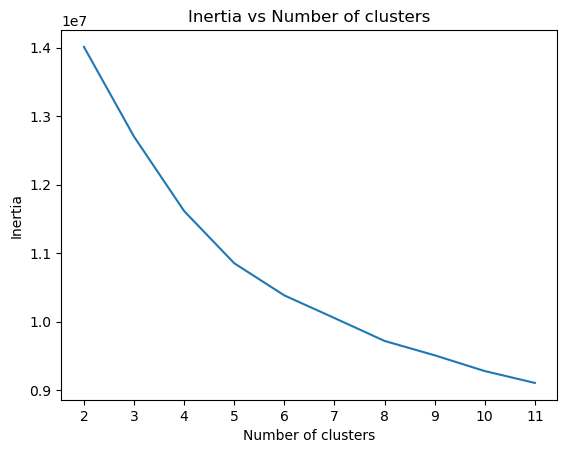

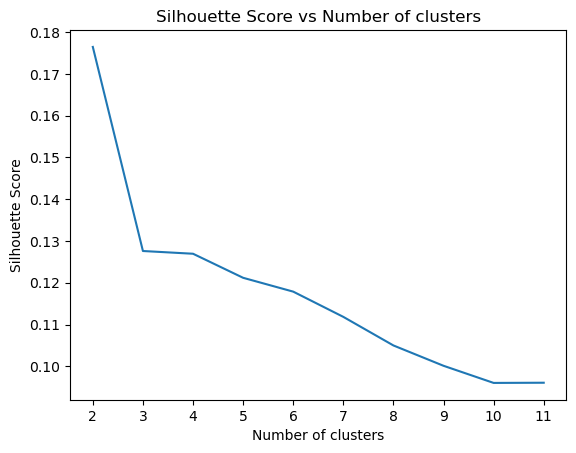

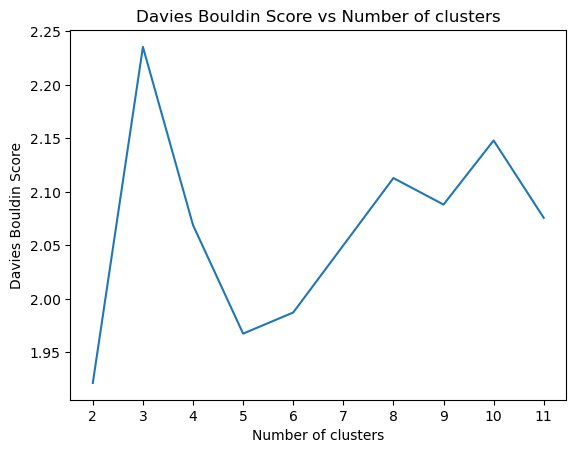

In [18]:
k_range = range(2, 12)
inertia_scores = []
silhouette_scores = []
davies_bouldin_scores = []
kmeans_models = []
for k in tqdm(k_range):
    model = KMeans(n_clusters=k, random_state=0, n_init='auto')
    model.fit(data_powertransform)
    kmeans_models.append(model)
    inertia_scores.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_powertransform, model.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(data_powertransform, model.labels_))

plt.plot(k_range, inertia_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of clusters')
plt.xticks(k_range)
plt.show()

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of clusters')
plt.xticks(k_range)
plt.show()

plt.plot(k_range, davies_bouldin_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Score vs Number of clusters')
plt.xticks(k_range)
plt.show()

In [19]:
with open('kmeans_models.pkl', 'wb') as f:
    pickle.dump(kmeans_models, f)

## DBSCAN clustering

For finding the optimal parameters, we are going to use the information from this article: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

From there, knowing we have 29 dimensions, the min_samples should be around $2 \cdot 29 = 58$

For caculating the eps, we are going yo use the NearestNeighbors algorithm to calculate the distance to the 58th nearest neighbor:

In [45]:
neigh = NearestNeighbors(n_neighbors=29*2)
nbrs = neigh.fit(data_powertransform)
distances, indices = nbrs.kneighbors(data_powertransform)

In [46]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = px.line(x= np.arange(0, len(distances)), 
              y=distances, 
              title='Points sorted by distance to the 58th nearest neighbor',
              labels={'x':'Point', 'y':'Distance to the 58th nearest neighbor'})
fig.show()

According to the plot, the optimal eps should be around 8.5 or 9.5.

We will try various values of eps and min_samples to find the optimal parameters:

From our experiments, we noticed the min_pts does not seem to have much influence in the range [56, 60], so we will use 58 as the min_pts.

100%|██████████| 12/12 [18:24<00:00, 92.05s/it]


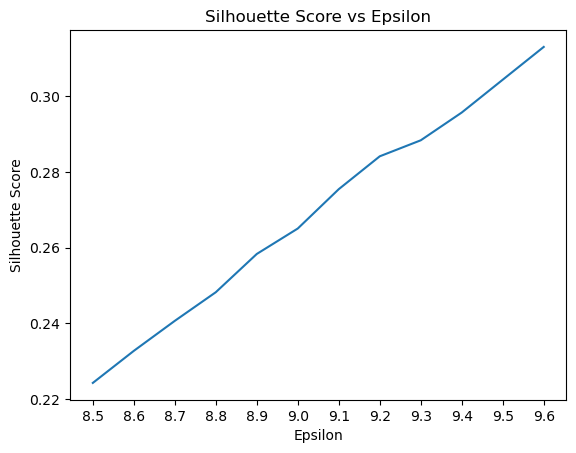

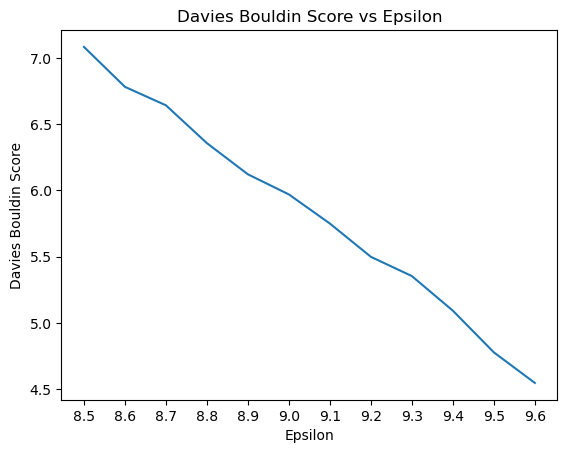

In [22]:
min_pts_range = [58]
eps_range = np.arange(8.5, 9.7, 0.1)
combined = list(product(min_pts_range, eps_range))

silhouette_scores = []
davies_bouldin_scores = []
dbscan_models = []
for min_pts, eps in tqdm(combined):
    np.random.seed(0)
    random.seed(0)
    model = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1)
    model.fit(data_powertransform)
    dbscan_models.append(model)
    try:
        silhouette_scores.append(silhouette_score(data_powertransform, model.labels_))
    except:
        silhouette_scores.append(-1)

    try:
        davies_bouldin_scores.append(davies_bouldin_score(data_powertransform, model.labels_))
    except:
        davies_bouldin_scores.append(1000)

plt.plot(eps_range, silhouette_scores)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Epsilon')
plt.xticks(eps_range)
plt.show()

plt.plot(eps_range, davies_bouldin_scores)
plt.xlabel('Epsilon')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Score vs Epsilon')
plt.xticks(eps_range)
plt.show()

In [23]:
with open('dbscan_models.pkl', 'wb') as f:
    pickle.dump(dbscan_models, f)

We can see that DBSCAN did not perform as well as KMeans, since DBSCAN assumes the clusters are of similar density, which is not the case in this dataset.

It also seems quite unstable, either not finding any clusters, or finding one big cluster and a lot of noise, or crashing due to memory issues.

## Gaussian Mixture clustering

We are going to use GMM, which is quite similar to KMeans, but instead of assigning each point to a cluster, it assigns a probability of belonging to each cluster.

100%|██████████| 10/10 [3:02:28<00:00, 1094.89s/it] 


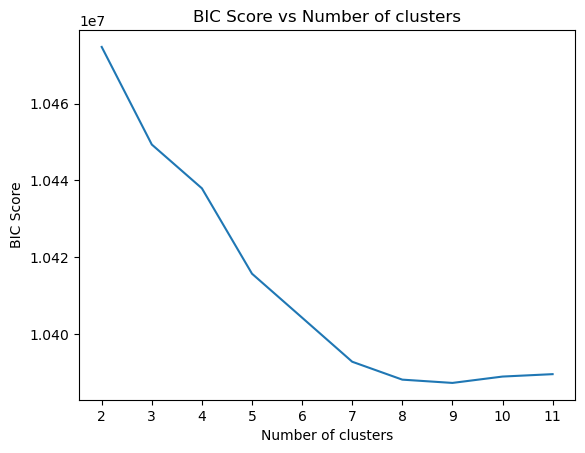

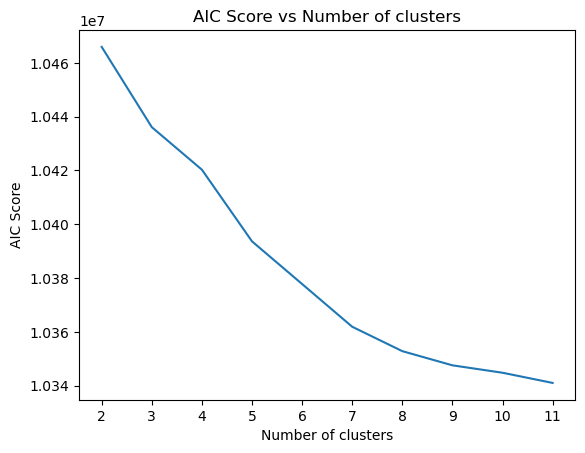

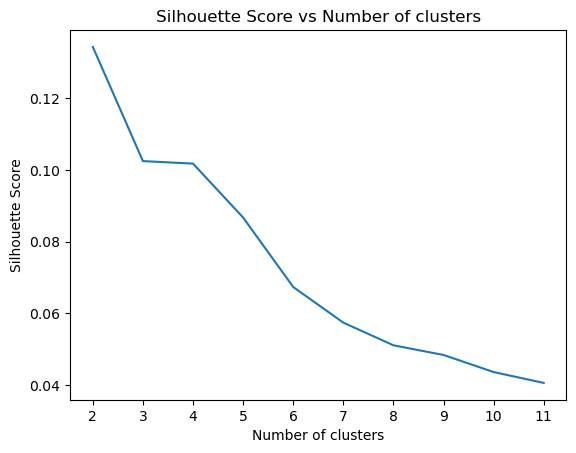

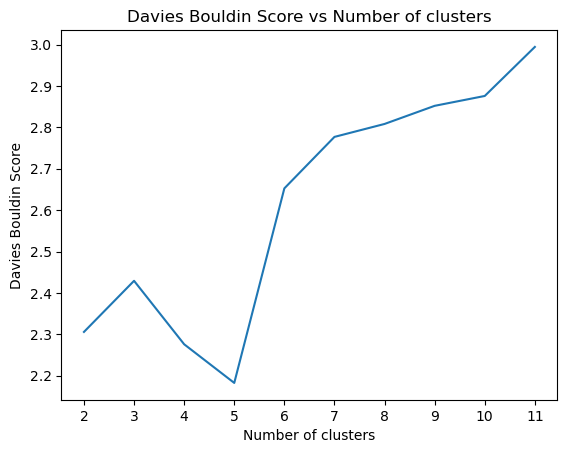

In [24]:
k_range = range(2, 12)
gmm_models = []
bic_scores = []
aic_scores = []
silhouette_scores = []
davies_bouldin_scores = []
for k in tqdm(k_range):
    model = GaussianMixture(n_components=k, random_state=0)
    model.fit(data_powertransform)
    gmm_models.append(model)
    bic_scores.append(model.bic(data_powertransform))
    aic_scores.append(model.aic(data_powertransform))
    silhouette_scores.append(silhouette_score(data_powertransform, model.predict(data_powertransform)))
    davies_bouldin_scores.append(davies_bouldin_score(data_powertransform, model.predict(data_powertransform)))

plt.plot(k_range, bic_scores)
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.title('BIC Score vs Number of clusters')
plt.xticks(k_range)
plt.show()

plt.plot(k_range, aic_scores)
plt.xlabel('Number of clusters')
plt.ylabel('AIC Score')
plt.title('AIC Score vs Number of clusters')
plt.xticks(k_range)
plt.show()

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of clusters')
plt.xticks(k_range)
plt.show()


plt.plot(k_range, davies_bouldin_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Score vs Number of clusters')
plt.xticks(k_range)
plt.show()

Like in KMeans, the best number of clusters seems to be 5.

In [25]:
with open('gmm_models.pkl', 'wb') as f:
    pickle.dump(gmm_models, f)

## Dimensionality reduction

We are going to use TruncatedSVD, TSNE and UMAP to reduce the dimensionality of the dataset and visualize it.

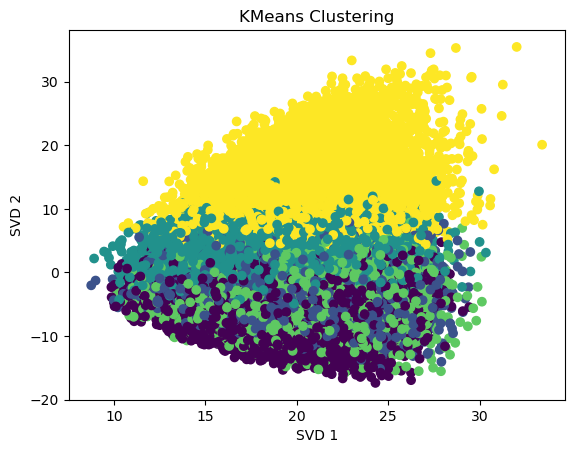

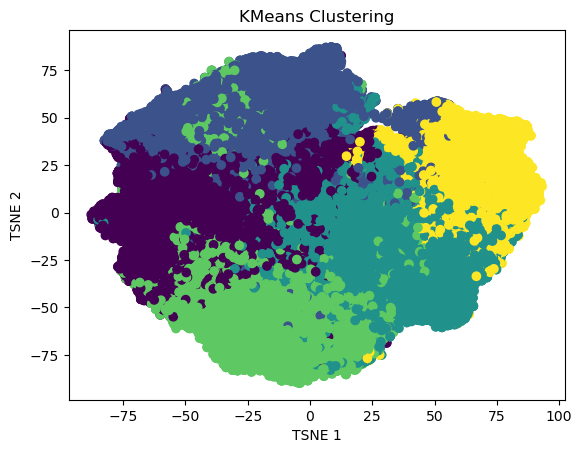

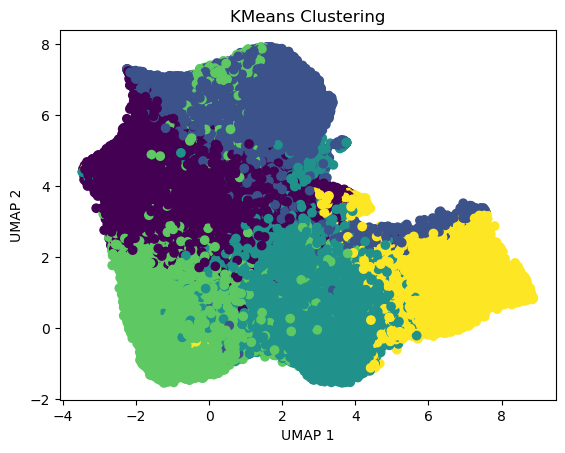

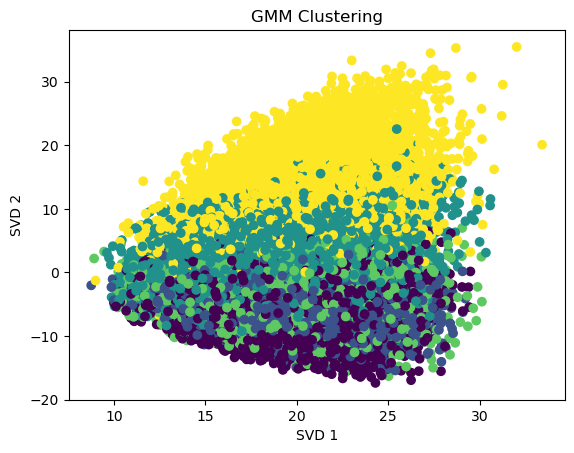

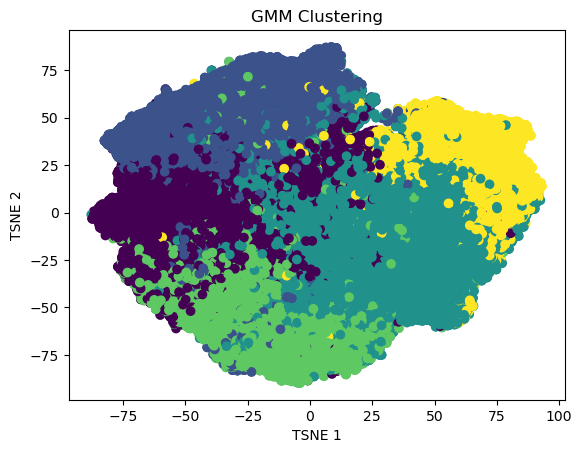

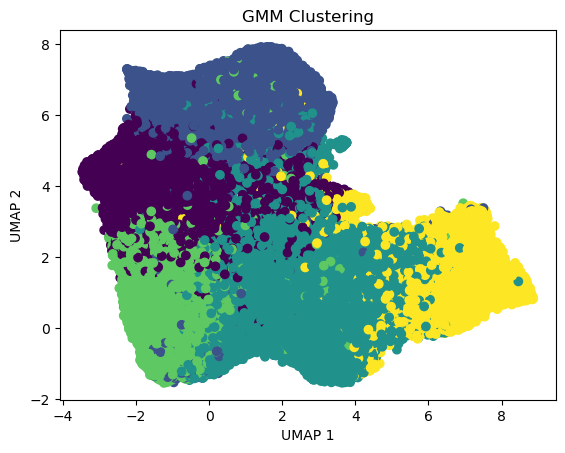

In [30]:
# Use dimensionality reduction to visualize the clusters
svd = TruncatedSVD(n_components=2, random_state=0)
svd_data = svd.fit_transform(data_powertransform)

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(data_powertransform)

umap = UMAP(n_components=2, random_state=0)
umap_data = umap.fit_transform(data_powertransform)

# Use the best clustering algorithm to cluster the data

# KMeans
kmeans_model = KMeans(n_clusters=5, random_state=0, n_init='auto')
kmeans_model.fit(data_powertransform)

# Plot the clusters
plt.scatter(svd_data[:, 0], svd_data[:, 1], c=kmeans_model.labels_, cmap='viridis')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.title('KMeans Clustering')
plt.show()

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans_model.labels_, cmap='viridis')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('KMeans Clustering')
plt.show()

plt.scatter(umap_data[:, 0], umap_data[:, 1], c=kmeans_model.labels_, cmap='viridis')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('KMeans Clustering')
plt.show()

# GMM
gmm_model = GaussianMixture(n_components=5, random_state=0)
gmm_model.fit(data_powertransform)

# Plot the clusters
plt.scatter(svd_data[:, 0], svd_data[:, 1], c=gmm_model.predict(data_powertransform), cmap='viridis')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.title('GMM Clustering')
plt.show()

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=gmm_model.predict(data_powertransform), cmap='viridis')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('GMM Clustering')
plt.show()

plt.scatter(umap_data[:, 0], umap_data[:, 1], c=gmm_model.predict(data_powertransform), cmap='viridis')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('GMM Clustering')
plt.show()

As we can see, the clusters given by KMeans and GMM are quite similar, however they do not seem to be very well separated.

In [29]:
with open('svd_data.pkl', 'wb') as f:
    pickle.dump(svd_data, f)

with open('tsne_data.pkl', 'wb') as f:
    pickle.dump(tsne_data, f)

with open('umap_data.pkl', 'wb') as f:
    pickle.dump(umap_data, f)

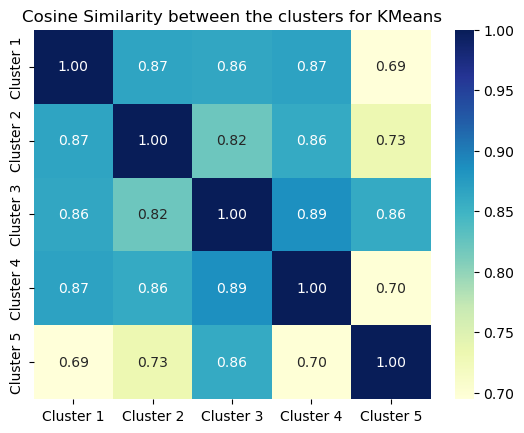

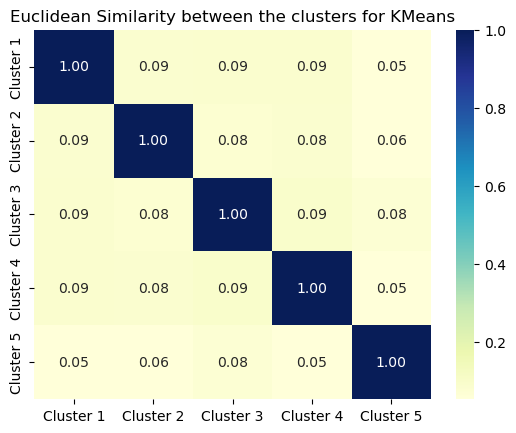

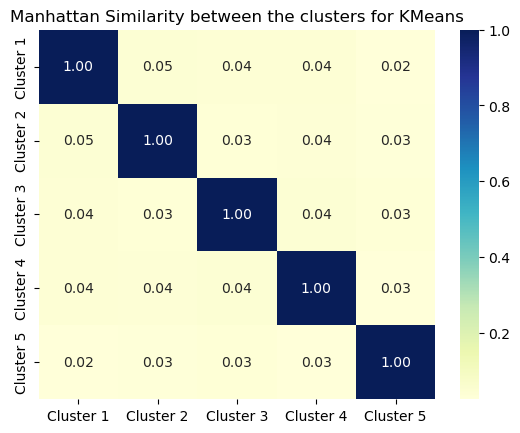

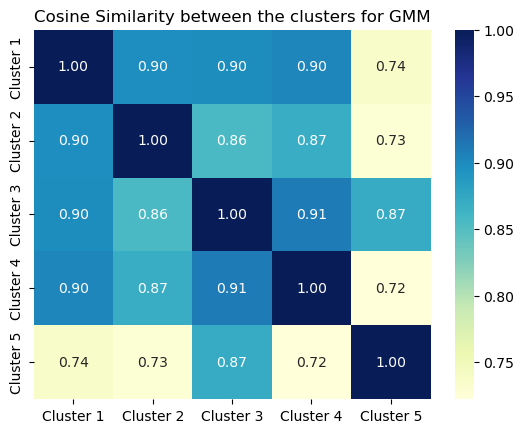

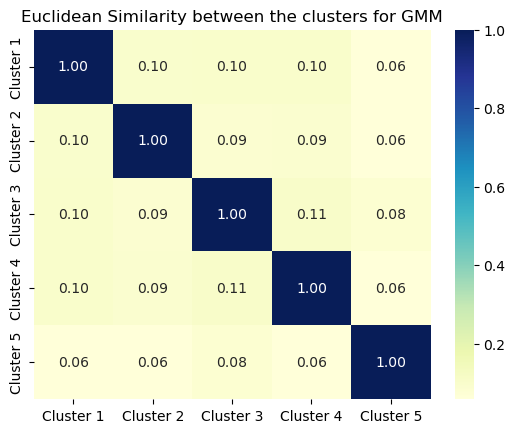

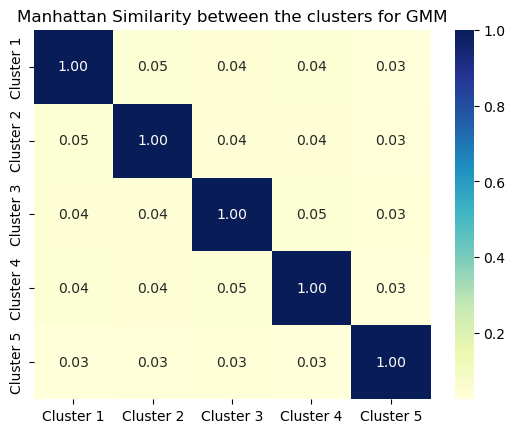

In [44]:
# For kmeans and gmm, we will use the best model to calculate the similarities between the clusters with a heatmap
# KMeans
kmeans_model = kmeans_models[3]

# Calculate the similarities between the clusters
cluster_similarity_cosine = cosine_similarity(kmeans_model.cluster_centers_)
cluster_similarity_cosine = pd.DataFrame(cluster_similarity_cosine, columns=[f'Cluster {i}' for i in range(1, cluster_similarity_cosine.shape[1] + 1)])
cluster_similarity_cosine.index = cluster_similarity_cosine.columns

cluster_similarity_euclidean = np.zeros((kmeans_model.cluster_centers_.shape[0], kmeans_model.cluster_centers_.shape[0]))
cluster_similarity_manhattan = np.zeros((kmeans_model.cluster_centers_.shape[0], kmeans_model.cluster_centers_.shape[0]))
for i in range(kmeans_model.cluster_centers_.shape[0]):
    for j in range(kmeans_model.cluster_centers_.shape[0]):
        cluster_similarity_euclidean[i, j] = 1 / (1 + np.linalg.norm(kmeans_model.cluster_centers_[i] - kmeans_model.cluster_centers_[j]))
        cluster_similarity_manhattan[i, j] = 1 / (1 + np.linalg.norm(kmeans_model.cluster_centers_[i] - kmeans_model.cluster_centers_[j], ord=1))

cluster_similarity_euclidean = pd.DataFrame(cluster_similarity_euclidean, columns=[f'Cluster {i}' for i in range(1, cluster_similarity_euclidean.shape[1] + 1)])
cluster_similarity_euclidean.index = cluster_similarity_euclidean.columns

cluster_similarity_manhattan = pd.DataFrame(cluster_similarity_manhattan, columns=[f'Cluster {i}' for i in range(1, cluster_similarity_manhattan.shape[1] + 1)])
cluster_similarity_manhattan.index = cluster_similarity_manhattan.columns

# Plot the heatmap
sns.heatmap(cluster_similarity_cosine, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Cosine Similarity between the clusters for KMeans')
plt.show()

sns.heatmap(cluster_similarity_euclidean, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Euclidean Similarity between the clusters for KMeans')
plt.show()

sns.heatmap(cluster_similarity_manhattan, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Manhattan Similarity between the clusters for KMeans')
plt.show()

# GMM
gmm_model = gmm_models[3]

# Calculate the similarities between the clusters
cluster_similarity_cosine = cosine_similarity(gmm_model.means_)
cluster_similarity_cosine = pd.DataFrame(cluster_similarity_cosine, columns=[f'Cluster {i}' for i in range(1, cluster_similarity_cosine.shape[1] + 1)])
cluster_similarity_cosine.index = cluster_similarity_cosine.columns

gmm_cluster_centers = gmm_model.means_

cluster_similarity_euclidean = np.zeros((gmm_model.means_.shape[0], gmm_model.means_.shape[0]))
cluster_similarity_manhattan = np.zeros((gmm_model.means_.shape[0], gmm_model.means_.shape[0]))
for i in range(gmm_model.means_.shape[0]):
    for j in range(gmm_model.means_.shape[0]):
        cluster_similarity_euclidean[i, j] = 1 / (1 + np.linalg.norm(gmm_model.means_[i] - gmm_model.means_[j]))
        cluster_similarity_manhattan[i, j] = 1 / (1 + np.linalg.norm(gmm_model.means_[i] - gmm_model.means_[j], ord=1))

cluster_similarity_euclidean = pd.DataFrame(cluster_similarity_euclidean, columns=[f'Cluster {i}' for i in range(1, cluster_similarity_euclidean.shape[1] + 1)])
cluster_similarity_euclidean.index = cluster_similarity_euclidean.columns

cluster_similarity_manhattan = pd.DataFrame(cluster_similarity_manhattan, columns=[f'Cluster {i}' for i in range(1, cluster_similarity_manhattan.shape[1] + 1)])
cluster_similarity_manhattan.index = cluster_similarity_manhattan.columns

# Plot the heatmap
sns.heatmap(cluster_similarity_cosine, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Cosine Similarity between the clusters for GMM')
plt.show()

sns.heatmap(cluster_similarity_euclidean, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Euclidean Similarity between the clusters for GMM')
plt.show()

sns.heatmap(cluster_similarity_manhattan, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Manhattan Similarity between the clusters for GMM')
plt.show()


It seems that there is a cluster that can be differentiated more easily from the rest (cluster 5), however the cluster's centroids disttances are very similar between each other. This is expected, due to how these two algorithms work.

## Conclusions

We have seen that the dataset is quite difficult to cluster, since the points do not appear to be evenly distributed, so algorithms like DBSCAN do not perform well.

We have also seen that the clusters given by KMeans and GMM are very similar, and both seem to give promising results, however they do not seem to be very well separated.

If we were to choose a clustering algorithm, we would choose GMM, since it seems to give similar results to KMeans, but it is more flexible when it comes to cluster shape, since it uses probability distributions instead of centroids.